The intersection seem to have the highly DE genes enriched (which is a good thing):

In [1301]:
intersection_tmm = set(significant_deseq2) & set(significant_ensembl(definite_tb_cm_limma_cmp_filtered['voom_tmm']))

In [1302]:
comparison = concat([
    definite_tb_cm_limma_cmp_filtered['voom_tmm'][['adj.P.Val']].rename({'adj.P.Val': 'padj'}, axis=1).rank(method='first').loc[intersection_tmm].assign(method='voom-TMM'),
    reference_definite_tbm_cm_deg.set_index('ensembl_id')[['padj']].rank(method='first').loc[intersection_tmm].assign(method='DESeq2 dr Rachel'),
]).rename_axis('gene').reset_index()

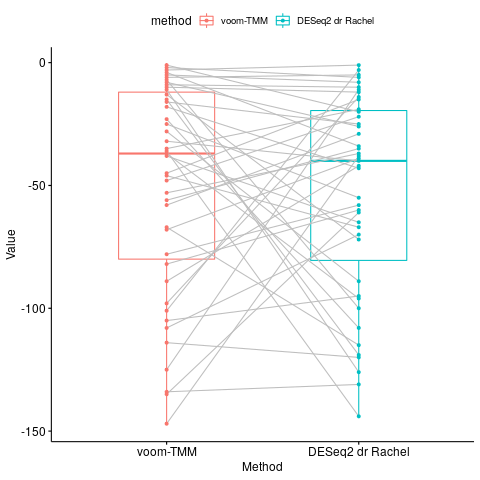

In [1303]:
%%R -i comparison
(
    ggpubr::ggpaired(
        comparison, x='method', y='-padj',
        color='method', line.color='gray', xlab='Method'
    )
)

The outliers detected in the preliminary analysis by dr Rachel are the same as detected here:

In [1304]:
%%R
reference_patients = by_condition_and_tb_subset[reference_samples, drop=F]
stopifnot(
    all(by_condition_and_tb_subset_no_outliers == reference_patients)
)

In [1305]:
%%R
library("BiocParallel")
register(MulticoreParam(6))

In [412]:
%%R -i reference_definite_tbm_cm_deg
conditions_for_deseq = factor(
    space_to_dot(
        by_condition_and_tb_subset[reference_samples, drop=F]
    )
)

dds_reproduction <- DESeq2::DESeqDataSetFromMatrix(
    countData = round(raw_counts_matrix[
        reference_definite_tbm_cm_deg$ensembl_id, 
        reference_samples
    ]),
    colData = as.data.frame(conditions_for_deseq),
    design = ~ conditions_for_deseq
)
dds_reproduction <- DESeq2::DESeq(dds_reproduction)

converting counts to integer mode
estimating size factors
estimating dispersions
gene-wise dispersion estimates
mean-dispersion relationship
final dispersion estimates
fitting model and testing
-- replacing outliers and refitting for 14 genes
-- DESeq argument 'minReplicatesForReplace' = 7 
-- original counts are preserved in counts(dds)
estimating dispersions
fitting model and testing


In [256]:
%%R
library(DESeq2) # Note it seems that IHW relies on DESeq2 without proper prefixing, hence import into global namespace is necessary

In [414]:
%%R -o deseq2_with_filtering_reproduction -o deseq2_with_weighting_reproduction
deseq2_with_filtering_reproduction = get_deseq_definite_tb_cm(dds_reproduction)
deseq2_with_weighting_reproduction = get_deseq_definite_tb_cm(dds_reproduction, filterFun=IHW::ihw)

Like-for-like comparison against voom:

In [342]:
%%R
conditions_for_deseq = factor(
    space_to_dot(by_condition_and_tb_subset_no_outliers)
)

dds_edger_prefiltered <- DESeq2::DESeqDataSetFromMatrix(
    countData = round(raw_counts_matrix[
        rownames(c_dge_tb_subsets_filtered$counts),
        names(by_condition_and_tb_subset_no_outliers)
    ]),
    colData = as.data.frame(conditions_for_deseq),
    design = ~ conditions_for_deseq
)
dds_edger_prefiltered <- DESeq2::DESeq(dds_edger_prefiltered)

converting counts to integer mode
estimating size factors
estimating dispersions
gene-wise dispersion estimates
mean-dispersion relationship
final dispersion estimates
fitting model and testing
-- replacing outliers and refitting for 218 genes
-- DESeq argument 'minReplicatesForReplace' = 7 
-- original counts are preserved in counts(dds)
estimating dispersions
fitting model and testing


In [ ]:
%%R
import::here(get_deseq_definite_tb_cm, .from='helpers/differential_expression.R')
import::here(de_comparison_pairplot, .from='plots/differential_expression.R')

In [517]:
%%R -o deseq2_with_filtering_apeglm -o deseq2_with_filtering_normal -o deseq2_with_filtering_ashr
deseq2_with_filtering_ashr = get_deseq_definite_tb_cm(dds_edger_prefiltered, shrinkage='ashr')
deseq2_with_filtering_apeglm = get_deseq_definite_tb_cm(dds_edger_prefiltered, shrinkage='apeglm')
deseq2_with_filtering_normal = get_deseq_definite_tb_cm(dds_edger_prefiltered, shrinkage='normal')

found results columns, replacing these
using 'ashr' for LFC shrinkage. If used in published research, please cite:
    Stephens, M. (2016) False discovery rates: a new deal. Biostatistics, 18:2.
    https://doi.org/10.1093/biostatistics/kxw041
found results columns, replacing these
using 'apeglm' for LFC shrinkage. If used in published research, please cite:
    Zhu, A., Ibrahim, J.G., Love, M.I. (2018) Heavy-tailed prior distributions for
    sequence count data: removing the noise and preserving large differences.
    Bioinformatics. https://doi.org/10.1093/bioinformatics/bty895
found results columns, replacing these
using 'normal' for LFC shrinkage, the Normal prior from Love et al (2014).
additional priors are available via the 'type' argument, see ?lfcShrink for details


In [415]:
%%R -o deseq2_with_filtering -o deseq2_without_filtering -o deseq2_with_weighting
deseq2_with_filtering = get_deseq_definite_tb_cm(dds_edger_prefiltered)
deseq2_without_filtering = get_deseq_definite_tb_cm(dds_edger_prefiltered, independentFiltering=F)
deseq2_with_weighting = get_deseq_definite_tb_cm(dds_edger_prefiltered, filterFun=IHW::ihw)

In [1858]:
from helpers.de_comparisons import generate_comparison, voom_cols, deseq_cols

p_values = {
    **{
        f'{method_id}_filtered': data[list(voom_cols)].rename(voom_cols, axis=1)
        for method_id, data in definite_tb_cm_limma_cmp_filtered.items()
    },
    **{
        f'{method_id}_no_filter': data[list(voom_cols)].rename(voom_cols, axis=1)
        for method_id, data in definite_tb_cm_cmp.items()
    },
    **{
        'deseq2_shrinkage_ashr': deseq2_with_filtering_ashr[deseq_cols],
        'deseq2_shrinkage_apeglm': deseq2_with_filtering_apeglm[deseq_cols],
        'deseq2_shrinkage_normal': deseq2_with_filtering_normal[deseq_cols],
        'deseq2_filtered': deseq2_with_filtering[deseq_cols],
        'deseq2_weighted': deseq2_with_weighting[deseq_cols],
        'deseq2_reproduction': deseq2_with_filtering_reproduction[deseq_cols],
        'deseq2_no_filter': deseq2_without_filtering[deseq_cols],
        'deseq2_Rachel': reference_definite_tbm_cm_deg[deseq_cols]
    }
}

In [492]:
filtered_comparisons = generate_comparison(p_values, ['deseq2_filtered', 'voom_tmm_filtered', 'voom_rle_filtered'])

Correlation is calculated for transcripts which were included in both compared analyses (so not rejected in pre-filtering step) and not rejected by the independent hypothesis filter:

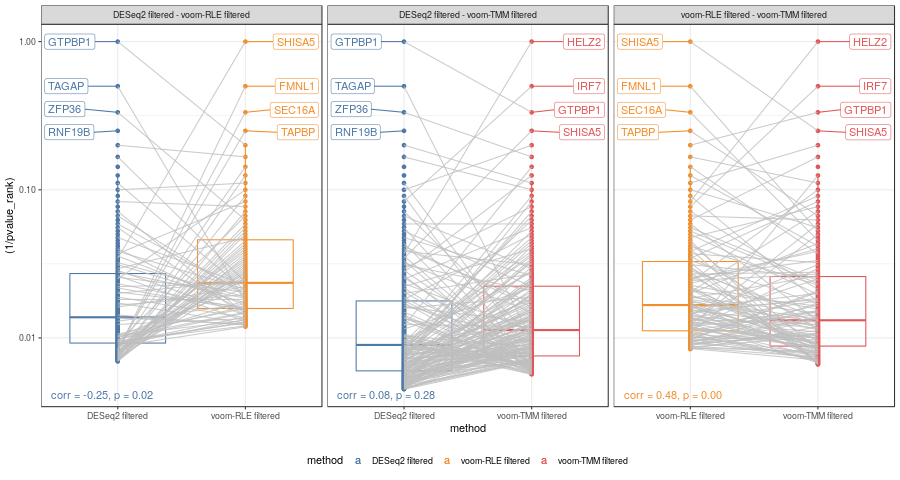

In [485]:
%%R -i filtered_comparisons -w 900
de_comparison_pairplot(filtered_comparisons)

In [487]:
plain_comparisons = generate_comparison(
    ['deseq2_no_filter', 'voom_tmm_no_filter', 'voom_rle_no_filter'],
    threshold=0.1
)

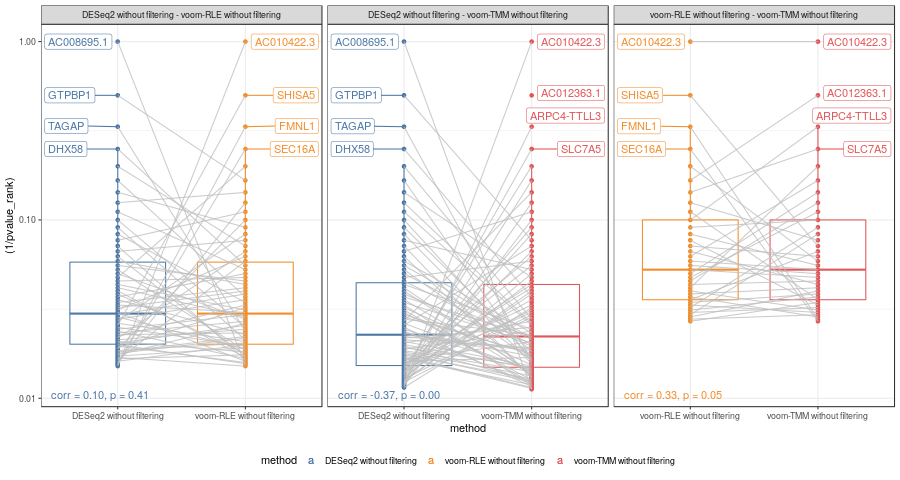

In [433]:
%%R -i plain_comparisons -w 900
de_comparison_pairplot(plain_comparisons)

In [435]:
deseq_comparison = generate_comparison(['deseq2_no_filter', 'deseq2_filtered', 'deseq2_Rachel'])

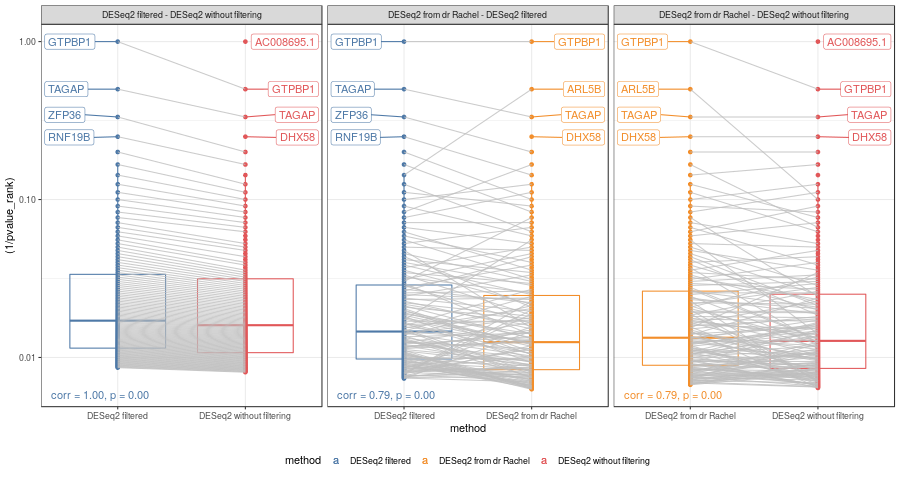

In [436]:
%%R -i deseq_comparison -w 900
de_comparison_pairplot(deseq_comparison)

Demonstration that the log-fold shrinkage is not related to the testing procedure in DESeq2:

In [1860]:
shrinkage_comparison = generate_comparison(['deseq2_shrinkage_apeglm', 'deseq2_shrinkage_ashr', 'deseq2_shrinkage_normal'])

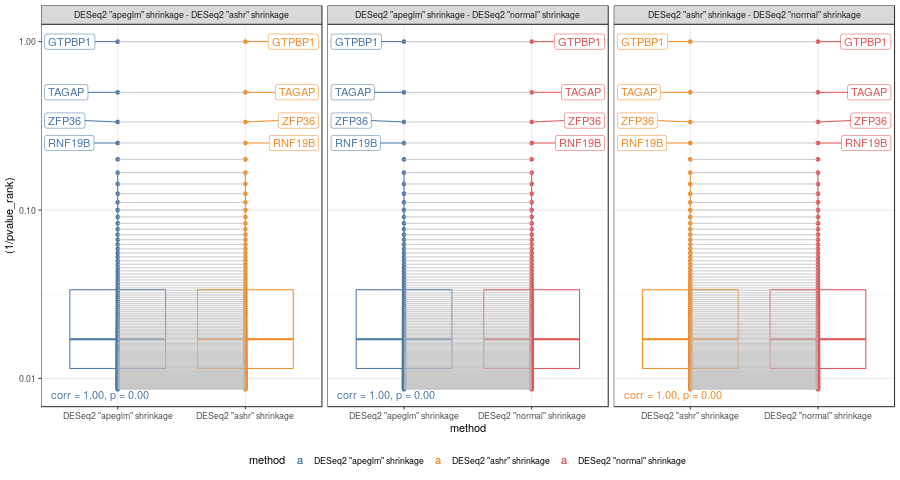

In [522]:
%%R -i shrinkage_comparison -w 900
de_comparison_pairplot(shrinkage_comparison)

In [790]:
voom_comparisons = generate_comparison(['voom_eee_filtered', 'voom_tmm_filtered', 'voom_rle_filtered'])

Note: EEE was adopted and actually means: TMM, voom, TMM!

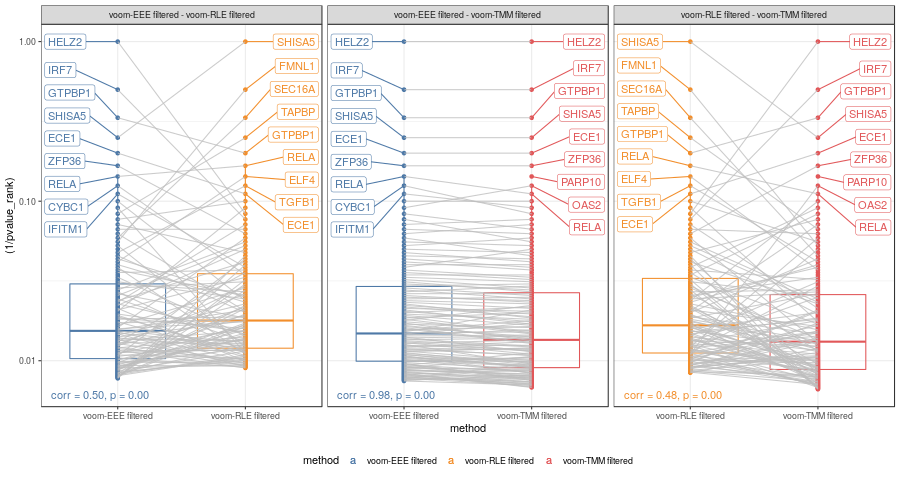

In [798]:
%%R -i voom_comparisons -w 900
de_comparison_pairplot(voom_comparisons, 10)

In [1862]:
qtotal_comparisons = generate_comparison(['voom_qtotal_filtered', 'voom_tmm_filtered', 'deseq2_filtered'])

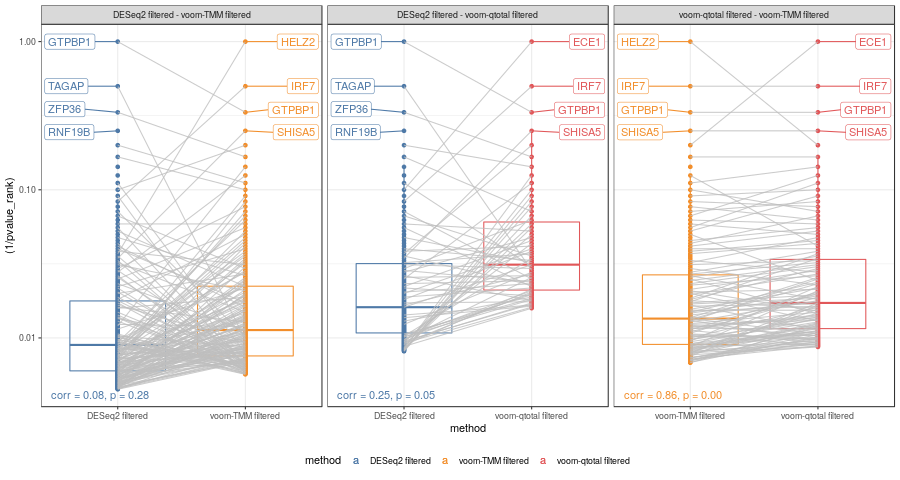

In [1864]:
%%R -i qtotal_comparisons -w 900
de_comparison_pairplot(qtotal_comparisons)

In [1344]:
qtotal_comparisons_no_filter = generate_comparison(['voom_qtotal_no_filter', 'voom_tmm_no_filter', 'deseq2_no_filter'])

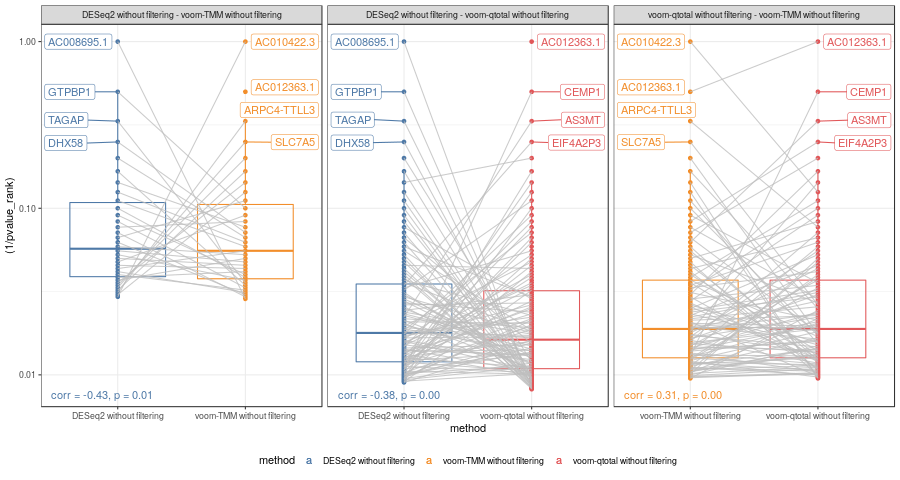

In [1346]:
%%R -i qtotal_comparisons_no_filter -w 900
de_comparison_pairplot(qtotal_comparisons_no_filter)

In [437]:
reproduction_comparison = generate_comparison(['deseq2_reproduction', 'deseq2_filtered', 'deseq2_Rachel'])

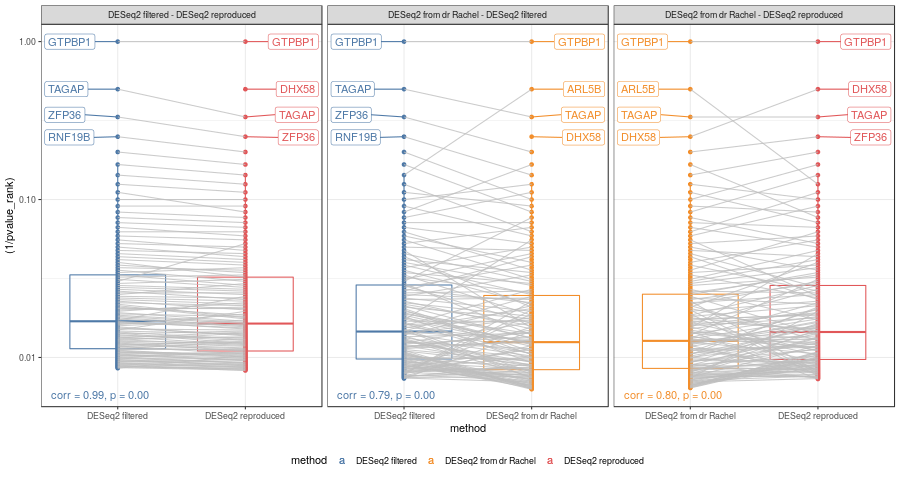

In [438]:
%%R -i reproduction_comparison -w 900
de_comparison_pairplot(reproduction_comparison)

In [441]:
from scipy.stats import pearsonr

In [442]:
ref = reference_definite_tbm_cm_deg
repro = deseq2_with_filtering_reproduction.loc[ref.index]
pearsonr(repro['log2FoldChange'], ref['log2FoldChange'])

(0.9884259288818367, 0.0)

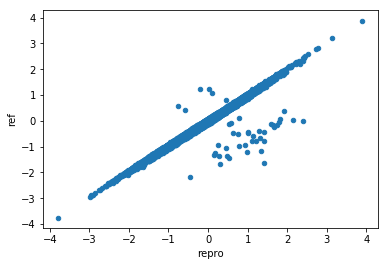

In [445]:
df = with_gene_data(DataFrame(dict(
    repro=repro['log2FoldChange'],
    ref=ref['log2FoldChange']
)), sort=False)
df.plot.scatter(x='repro', y='ref');

Interesting..

In [448]:
df['difference'] = abs(df.repro - df.ref)
df['p_ref'] = ref['padj']
df['p_repro'] = repro['padj']
df['voom'] = definite_tb_cm_limma_cmp_filtered['voom_tmm'].loc[ref.index].logFC

In [449]:
from scipy.stats import zscore

In [450]:
lfc_outliers = df[zscore(df.difference) > 2]
show_table(lfc_outliers.sort_values('difference'))

,repro,ref,gene_name,biotype,contig,strand,difference,p_ref,p_repro,voom
ENSG00000211892,0.450181,0.798702,IGHG4,IG_C_gene,14,-,0.348521,NaN,NaN,1.966573
ENSG00000132463,0.535183,-0.119796,GRSF1,protein_coding,4,-,0.654979,0.886299,0.433663,0.292903
ENSG00000188542,0.584919,-0.077051,DUSP28,protein_coding,2,+,0.661970,0.959831,NaN,0.169763
ENSG00000100307,0.782972,0.096994,CBX7,protein_coding,22,-,0.685978,0.947972,0.217790,0.445430
ENSG00000211938,0.108468,1.074797,IGHV3-7,IG_V_gene,14,-,0.966328,NaN,0.994394,2.127016
ENSG00000252010,-0.579511,0.415941,SCARNA5,scaRNA,2,+,0.995452,NaN,NaN,0.468971
ENSG00000211890,0.627704,-0.452663,IGHA2,IG_C_gene,14,-,1.080368,0.911712,0.828043,1.690657
ENSG00000170448,0.255641,-0.923274,NFXL1,protein_coding,4,-,1.178915,0.362769,0.949664,-0.325118
ENSG00000224650,0.028125,1.218261,IGHV3-74,IG_V_gene,14,-,1.190136,NaN,NaN,2.706474
ENSG00000119969,0.760992,-0.524589,HELLS,protein_coding,10,+,1.285581,0.453210,0.469943,-0.167385


Fortunately, none of the genes with flipping fold-changes were nominated as significant.

First guess: something related to shrinkage must have changed in DESeq2 in between the two analyzes.

Relevant posts:
 - https://support.bioconductor.org/p/100978/
 - https://support.bioconductor.org/p/75330/
 - https://support.bioconductor.org/p/85373/
 
Also:
 > Here we extend the discussion of shrinkage estimators. To repeat, the current default method in lfcShrink is normal, although it will likely change in the October 2018 release to apeglm, as this method has improved performance relative to the original DESeq2 estimator, as does ashr in some of our benchmarks. Below is a summary table of differences between methods available in lfcShrink via the type argument (and for further technical reference on use of arguments please see ?lfcShrink):

And more importantly:
 
> In version 1.16 (November 2016), the log2 fold change shrinkage is no longer default for the DESeq and nbinomWaldTest functions, by setting the defaults of these to betaPrior=FALSE, and by introducing a separate function lfcShrink, which performs log2 fold change shrinkage for visualization and ranking of genes. While for the majority of bulk RNA-seq experiments, the LFC shrinkage did not affect statistical testing, DESeq2 has become used as an inference engine by a wider community, and certain sequencing datasets show better performance with the testing separated from the use of the LFC prior. Also, the separation of LFC shrinkage to a separate function lfcShrink allows for easier methods development of alternative effect size estimators.

 (http://bioconductor.org/packages/devel/bioc/vignettes/DESeq2/inst/doc/DESeq2.html)

In [542]:
%%R -o ref_ashr -o ref_apeglm -o ref_normal
ref_ashr = get_deseq_definite_tb_cm(dds_reproduction, shrinkage='ashr')
ref_apeglm = get_deseq_definite_tb_cm(dds_reproduction, shrinkage='apeglm')
ref_normal = get_deseq_definite_tb_cm(dds_reproduction, shrinkage='normal')

found results columns, replacing these
using 'ashr' for LFC shrinkage. If used in published research, please cite:
    Stephens, M. (2016) False discovery rates: a new deal. Biostatistics, 18:2.
    https://doi.org/10.1093/biostatistics/kxw041
found results columns, replacing these
using 'normal' for LFC shrinkage, the Normal prior from Love et al (2014).
additional priors are available via the 'type' argument, see ?lfcShrink for details
found results columns, replacing these
using 'apeglm' for LFC shrinkage. If used in published research, please cite:
    Zhu, A., Ibrahim, J.G., Love, M.I. (2018) Heavy-tailed prior distributions for
    sequence count data: removing the noise and preserving large differences.
    Bioinformatics. https://doi.org/10.1093/bioinformatics/bty895


In [604]:
shrinkage_comparison = with_gene_data(pd.concat([
        DataFrame(dict(
        with_shrinkage=result.loc[ref.index]['log2FoldChange'],
        without_shrinkage=repro['log2FoldChange'],
        padj=ref['padj'],
        baseMean=ref['baseMean']
    )).assign(shrinkage=name)
    for name, result in {
        'ashr': ref_ashr, 'apeglm': ref_apeglm, 'normal': ref_normal
    }.items()
]), sort=False, include=['gene_name'])

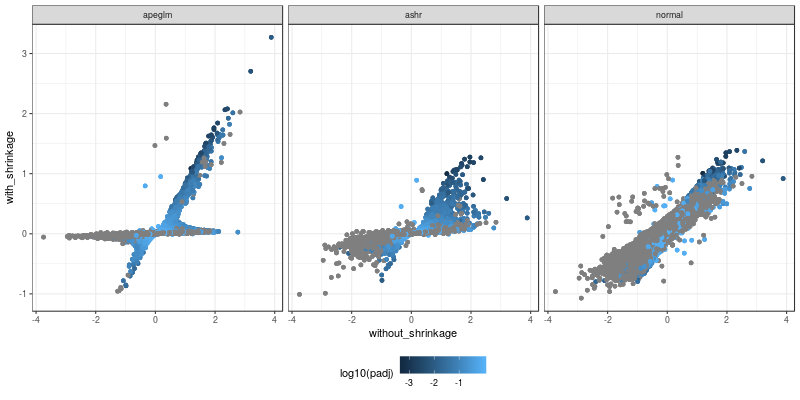

In [606]:
%%R -w 800 -h 400 -i shrinkage_comparison
(
    ggplot(shrinkage_comparison, aes(
        x=without_shrinkage,
        y=with_shrinkage,
        color=log10(padj)
    ))
    + geom_point()
    + facet_wrap('shrinkage')
    + nice_theme
)

It's not ashr shrinkage, for certain. Normal shrinkage looks similar, but the less than no shrinkage.

Also, how does it look like for voom?

In [608]:
definite_tb_cm_limma_cmp_filtered['voom_tmm'].loc[lfc_outliers.index].sort_values('P.Value')

,logFC,AveExpr,t,P.Value,adj.P.Val,B,unfiltered.adj.P.Val
ENSG00000237480,-1.638620,1.755167,-2.998031,0.003858,NaN,-1.973117,0.235724
ENSG00000224650,2.706474,1.622972,2.449491,0.018069,NaN,-3.128040,0.336297
ENSG00000272808,-0.995549,2.363321,-1.912143,0.060307,NaN,-4.039648,0.444227
ENSG00000211895,1.778796,8.572389,1.924475,0.060869,0.135193,-4.295185,0.444856
ENSG00000211890,1.690657,6.858361,1.893763,0.064931,0.139169,-4.311502,0.453051
...,...,...,...,...,...,...,...
ENSG00000174640,0.075457,1.883128,0.116628,0.907518,NaN,-5.391943,0.974959
ENSG00000146677,-0.054824,0.453407,-0.105383,0.916400,NaN,-5.358293,0.978201
ENSG00000102452,-0.033391,1.561763,-0.042161,0.966501,NaN,-5.373010,0.990691
ENSG00000185689,0.015903,1.053453,0.024704,0.980368,NaN,-5.405566,0.995042


No worrying significant hits either, so these could be some unstable cases...

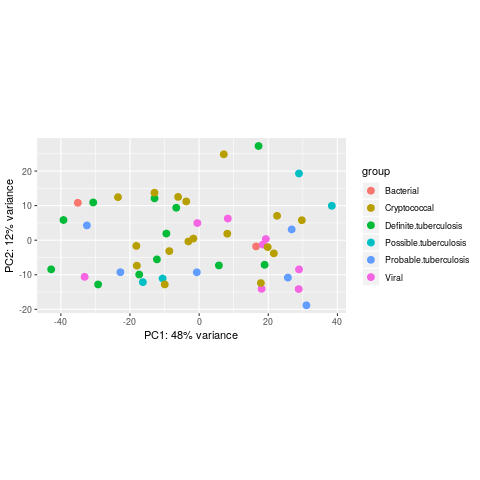

In [610]:
%%R
vsd <- vst(dds_edger_prefiltered, blind=FALSE)
plotPCA(vsd, intgroup='conditions_for_deseq')

The first few DE genes have good correspondence, but the remaining ones are quite shuffled.